In [1]:
import pandas as pd
dataset = pd.read_excel('IncidentiModificato.xlsx', sheet_name='Foglio1', index_col=0)
dataset.head()

,DATA,SESSO,ANNI,PESO,ALTEZZA,BMI,Mezzo,Testa:Neurocranio,Testa:Splancnocranio,Testa:Telencefalo,...,Scheletro:Rachide-cervicale,Scheletro:Rachide-toracico,Scheletro:Rachide-lombare,Scheletro:Bacino-e-sacro,Scheletro:Complesso-sterno/claveo/costale,Tot Testa,Tot Torace,Tot Addome,Tot Scheletro,Totale
VERBALE,,,,,,,,,,,,,,,,,,,,,
85567,1999-10-29,0,81,84.0,1.75,27.428571,0,1,0,0,...,0,3,0,3,3,2,0,3,9,14
85829,2000-01-14,1,69,69.0,1.62,26.291724,1,4,4,4,...,0,0,0,0,4,20,7,1,4,32
85977,2000-03-10,1,71,67.0,1.55,27.887617,1,2,0,1,...,0,0,0,0,4,6,0,0,4,10
86220,2000-06-14,1,54,60.0,1.59,23.733238,1,4,0,0,...,0,0,0,0,4,5,3,2,4,14
86247,2000-06-22,1,78,69.0,1.67,24.740937,1,2,0,0,...,0,0,0,0,4,2,0,2,4,8


In [2]:
len(dataset)

130

In [3]:
dataset.index.unique()

Index([    85567,     85829,     85977,     86220,     86247,     86421,
           86839,     86876,     86878,     90056,
       ...
          101097,    101180,    101189,    101544,    101583,    101618,
       '101288E', 'E-97586',       'X',      'X1'],
      dtype='object', name='VERBALE', length=130)

In [16]:
def checkDataset(dataset):
    #controllo che i verbali siano valori unici
    if (len(dataset.index) != len(dataset.index.unique())):
        raise Exception('I verbali non possono essere usati come indice')

    #controllo i valori degli anni
    anni = dataset['ANNI']
    for anno in anni:
        if anno < 1 or anno > 95:
            raise Exception(f'Anno inserito non valido {anno}')
    
    #controllo i valori dei pesi
    pesi = dataset['PESO']
    for peso in pesi:
        if peso < 30 or peso > 120:
            raise Exception(f'Peso inserito non valido {peso}')
    
    #controllo i valori dell'altezza
    altezze = dataset['ALTEZZA']
    for altezza in altezze:
        if altezza < 1.00 or altezza > 2.10:
            raise Exception(f'Altezza inserito non valida {altezza}')
    
    #controllo del BMI
    valori_BMI = dataset['BMI']
    for bmi in valori_BMI:
        if bmi < 10.0 or bmi > 50.0:
            raise Exception(f'bmi inserito non valido {bmi}')
            
    #controllo altri valori compresi tra 0 e 4
    dataset_valori_0_4 = dataset['Testa:Neurocranio']
    for valore in dataset_valori_0_4:
        if valore < 0 or valore > 4:
            raise Exception(f'{valore} non compresa tra 0 e 4')
            

    print("Valori del dataset corretti")
    

checkDataset(dataset)

Valori del dataset corretti


In [1]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score

def addestra(model_class, X, y, model_selection_grid, num_fold, scaling=None, dim_reduction=None):
    
    if scaling is not None:
        sc = scaling
        X_std = sc.fit_transform(X)
    
        if dim_reduction is not None: 
            reducer = dim_reduction
            X_std = reducer.fit_transform(X_std)

    clf = GridSearchCV(estimator=model_class(), param_grid=model_selection_grid, cv=num_fold, iid=True)
    return cross_val_score(clf, X_std, y, cv=9)

#For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used

## Iniziamo considerando solo i totali per distretto

In [25]:
X_total = dataset[['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y_total = dataset['Mezzo']

In [26]:
from sklearn.svm import SVC

c_space = np.logspace(-4, 3, 10)
gamma_space = np.logspace(-4, 3, 10)

model_selection_grid = [
  {'C': c_space, 'kernel': ['linear'], 'gamma': ['auto']},
  {'C': c_space, 'gamma': gamma_space, 'kernel': ['rbf']},
  {'C': c_space, 'gamma': ['auto', 'scale'], 'kernel': ['rbf']},
  {'C': c_space, 'degree': [2, 3, 5, 9], 'kernel': ['poly'], 'gamma': ['auto']},
 ]

np.mean(addestra(SVC, X_total, y_total, model_selection_grid, 9, ))

/home/ale/anaconda3/envs/Tesi/lib/python3.7/site-packages/sklearn/model_selection/_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


TypeError: can't pickle generator objects

In [56]:
from sklearn.tree import DecisionTreeClassifier

model_selection_grid = {'criterion': ['gini', 'entropy'],
                        'max_leaf_nodes': [None, 2, 5, 10, 50, 100],
                        'max_features': [None, 'sqrt', 'log2'],
                        'max_depth': [None, 2, 5, 10]}

np.mean(addestra(DecisionTreeClassifier, X_total, y_total, model_selection_grid, 9))

0.5774114774114775

In [57]:
from sklearn.ensemble import RandomForestClassifier

model_selection_grid = {'n_estimators': [5, 10, 50, 100, 200],
                        'criterion': ['gini', 'entropy'],
                        'max_leaf_nodes': [None, 2, 5, 10, 50, 100],
                        'max_features': [None, 'sqrt', 'log2'],
                        'max_depth': [None, 2, 5, 10]}

np.mean(addestra(RandomForestClassifier, X_total, y_total, model_selection_grid, 9))

0.6297110297110297

In [58]:
from sklearn.naive_bayes import GaussianNB

model_selection_grid = {}

np.mean(addestra(GaussianNB, X_total, y_total, model_selection_grid, 9))

0.706064306064306

In [59]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model_selection_grid = {}

np.mean(addestra(LinearDiscriminantAnalysis, X_total, y_total, model_selection_grid, 9))

0.7192104192104192

In [63]:
from sklearn.neural_network import MLPClassifier

model_selection_grid = {'max_iter': [5000],
                        'hidden_layer_sizes': [[2], [4], [6], [10], [20], [4, 4], [10, 10]],
                        'activation': ['identity', 'logistic', 'tanh', 'relu']}

np.mean(addestra(MLPClassifier, X_total, y_total, model_selection_grid, 9))

0.6507936507936508

## Aumentiamo la precisione, scendendo nei cinque livelli di ogni distretto

In [15]:
selected_cols = ['Testa:Neurocranio',
                 'Testa:Splancnocranio',
                 'Testa:Telencefalo',
                 'Testa:Cervelletto',
                 'Testa:Tronco-encefalico',
                 'Torace:Polmoni',
                 'Torace:Trachea/bronchi',
                 'Torace:Cuore',
                 'Torace:Aorta-toracica',
                 'Torace:Diaframma',
                 'Addome:Fegato',
                 'Addome:Milza',
                 'Addome:Aorta-addominale',
                 'Addome:Reni',
                 'Addome:Mesentere',
                 'Scheletro:Rachide-cervicale',
                 'Scheletro:Rachide-toracico',
                 'Scheletro:Rachide-lombare',
                 'Scheletro:Bacino-e-sacro',
                 'Scheletro:Complesso-sterno/claveo/costale']

X_details = dataset[selected_cols]
y_details = dataset['Mezzo']

Iniziamo facendo un controllo su quanto sia possibile ridurre la dimensione dei dati

In [11]:
pca = PCA(n_components = 20)
pca.fit(X_details)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

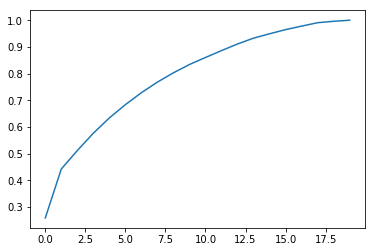

In [73]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.plot(range(20), pca.explained_variance_ratio_.cumsum())
plt.show()

In [74]:
pca.explained_variance_ratio_.cumsum()

array([0.2590028 , 0.4424267 , 0.51161017, 0.57652743, 0.63390248,
       0.68359398, 0.72846105, 0.7680911 , 0.80302776, 0.83411104,
       0.8604245 , 0.88623497, 0.91098428, 0.9328969 , 0.94926481,
       0.96485529, 0.97790404, 0.99078593, 0.99608975, 1.        ])

In [75]:
pca.explained_variance_ratio_.cumsum()[12]

0.9109842843806883

Scendendo quindi da 20 a 13 feature si mantiene più del 90% della varianza

### Iniziamo comunque con tutte le 20 feature

In [76]:
c_space = np.logspace(-4, 3, 10)
gamma_space = np.logspace(-4, 3, 10)

model_selection_grid = [
  {'C': c_space, 'kernel': ['linear'], 'gamma': ['auto']},
  {'C': c_space, 'gamma': gamma_space, 'kernel': ['rbf']},
  {'C': c_space, 'gamma': ['auto', 'scale'], 'kernel': ['rbf']},
  {'C': c_space, 'degree': [2, 3, 5, 9], 'kernel': ['poly'], 'gamma': ['auto']},
 ]

np.mean(addestra(SVC, X_details, y_details, model_selection_grid, 9))

0.6703296703296704

In [77]:
from sklearn.tree import DecisionTreeClassifier

model_selection_grid = {'criterion': ['gini', 'entropy'],
                        'max_leaf_nodes': [None, 2, 5, 10, 50, 100],
                        'max_features': [None, 'sqrt', 'log2'],
                        'max_depth': [None, 2, 5, 10]}

np.mean(addestra(DecisionTreeClassifier, X_details, y_details, model_selection_grid, 9))

0.6332519332519332

In [78]:
from sklearn.ensemble import RandomForestClassifier

model_selection_grid = {'n_estimators': [5, 10, 50, 100, 200],
                        'criterion': ['gini', 'entropy'],
                        'max_leaf_nodes': [None, 2, 5, 10, 50, 100],
                        'max_features': [None, 'sqrt', 'log2'],
                        'max_depth': [None, 2, 5, 10]}

np.mean(addestra(RandomForestClassifier, X_details, y_details, model_selection_grid, 9))

0.677045177045177

In [79]:
from sklearn.naive_bayes import GaussianNB

model_selection_grid = {}

np.mean(addestra(GaussianNB, X_details, y_details, model_selection_grid, 9))

0.6359788359788361

In [80]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model_selection_grid = {}

np.mean(addestra(LinearDiscriminantAnalysis, X_details, y_details, model_selection_grid, 9))

0.6433862433862434

In [81]:
from sklearn.neural_network import MLPClassifier

model_selection_grid = {'max_iter': [5000],
                        'hidden_layer_sizes': [[2], [4], [6], [10], [20], [4, 4], [10, 10]],
                        'activation': ['identity', 'logistic', 'tanh', 'relu']}

np.mean(addestra(MLPClassifier, X_details, y_details, model_selection_grid, 9))

0.6787138787138787

### Scendiamo a 13 feature con PCA

In [84]:
c_space = np.logspace(-4, 3, 10)
gamma_space = np.logspace(-4, 3, 10)

model_selection_grid = [
  {'C': c_space, 'kernel': ['linear'], 'gamma': ['auto']},
  {'C': c_space, 'gamma': gamma_space, 'kernel': ['rbf']},
  {'C': c_space, 'gamma': ['auto', 'scale'], 'kernel': ['rbf']},
  {'C': c_space, 'degree': [2, 3, 5, 9], 'kernel': ['poly'], 'gamma': ['auto']},
 ]

np.mean(addestra(SVC, X_details, y_details, model_selection_grid, 9, dim_reduction=PCA(n_components=13)))

0.6702482702482703

In [85]:
from sklearn.tree import DecisionTreeClassifier

model_selection_grid = {'criterion': ['gini', 'entropy'],
                        'max_leaf_nodes': [None, 2, 5, 10, 50, 100],
                        'max_features': [None, 'sqrt', 'log2'],
                        'max_depth': [None, 2, 5, 10]}

np.mean(addestra(DecisionTreeClassifier, X_details, y_details, model_selection_grid, 9, dim_reduction=PCA(n_components=13)))

0.6087098087098087

In [86]:
from sklearn.ensemble import RandomForestClassifier

model_selection_grid = {'n_estimators': [5, 10, 50, 100, 200],
                        'criterion': ['gini', 'entropy'],
                        'max_leaf_nodes': [None, 2, 5, 10, 50, 100],
                        'max_features': [None, 'sqrt', 'log2'],
                        'max_depth': [None, 2, 5, 10]}

np.mean(addestra(RandomForestClassifier, X_details, y_details, model_selection_grid, 9, dim_reduction=PCA(n_components=13)))

0.7105413105413105

In [87]:
from sklearn.naive_bayes import GaussianNB

model_selection_grid = {}

np.mean(addestra(GaussianNB, X_details, y_details, model_selection_grid, 9, dim_reduction=PCA(n_components=13)))

0.665079365079365

In [88]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model_selection_grid = {}

np.mean(addestra(LinearDiscriminantAnalysis, X_details, y_details, model_selection_grid, 9, dim_reduction=PCA(n_components=13)))

0.5881155881155881

In [89]:
from sklearn.neural_network import MLPClassifier

model_selection_grid = {'max_iter': [5000],
                        'hidden_layer_sizes': [[2], [4], [6], [10], [20], [4, 4], [10, 10]],
                        'activation': ['identity', 'logistic', 'tanh', 'relu']}

np.mean(addestra(MLPClassifier, X_details, y_details, model_selection_grid, 9, dim_reduction=PCA(n_components=13)))

0.5733007733007733

### Proviamo a ridurre le componenti a 10 con t-SNE

In [5]:
from sklearn.manifold import TSNE

In [6]:
from sklearn.svm import SVC

c_space = np.logspace(-4, 3, 10)
gamma_space = np.logspace(-4, 3, 10)

model_selection_grid = [
  {'C': c_space, 'kernel': ['linear'], 'gamma': ['auto']},
  {'C': c_space, 'gamma': gamma_space, 'kernel': ['rbf']},
  {'C': c_space, 'gamma': ['auto', 'scale'], 'kernel': ['rbf']},
  {'C': c_space, 'degree': [2, 3, 5, 9], 'kernel': ['poly'], 'gamma': ['auto']},
 ]

np.mean(addestra(SVC, X_details, y_details, model_selection_grid, 9, dim_reduction=TSNE(n_components=10, method='exact')))

0.46182336182336187

In [6]:
from sklearn.tree import DecisionTreeClassifier

model_selection_grid = {'criterion': ['gini', 'entropy'],
                        'max_leaf_nodes': [None, 2, 5, 10, 50, 100],
                        'max_features': [None, 'sqrt', 'log2'],
                        'max_depth': [None, 2, 5, 10]}

np.mean(addestra(DecisionTreeClassifier, X_details, y_details, model_selection_grid, 9, dim_reduction=TSNE(n_components=3)))

0.5164835164835164

In [7]:
from sklearn.ensemble import RandomForestClassifier

model_selection_grid = {'n_estimators': [5, 10, 50, 100, 200],
                        'criterion': ['gini', 'entropy'],
                        'max_leaf_nodes': [None, 2, 5, 10, 50, 100],
                        'max_features': [None, 'sqrt', 'log2'],
                        'max_depth': [None, 2, 5, 10]}

np.mean(addestra(RandomForestClassifier, X_details, y_details, model_selection_grid, 9, dim_reduction=TSNE(n_components=3)))

0.46923076923076923

In [9]:
from sklearn.naive_bayes import GaussianNB

model_selection_grid = {}

np.mean(addestra(GaussianNB, X_details, y_details, model_selection_grid, 9, dim_reduction=TSNE(n_components=3)))

0.5564509564509564

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model_selection_grid = {}

np.mean(addestra(LinearDiscriminantAnalysis, X_details, y_details, model_selection_grid, 9, dim_reduction=TSNE(n_components=3)))

0.5705331705331704

In [8]:
from sklearn.neural_network import MLPClassifier

model_selection_grid = {'max_iter': [5000],
                        'hidden_layer_sizes': [[2], [4], [6], [10], [20], [4, 4], [10, 10]],
                        'activation': ['identity', 'logistic', 'tanh', 'relu']}

np.mean(addestra(MLPClassifier, X_details, y_details, model_selection_grid, 9, dim_reduction=TSNE(n_components=3)))

0.522914122914123